<a href="https://colab.research.google.com/github/Mikceroese/ML/blob/main/ML_lab1_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import preprocessing
from keras.datasets import cifar10
import cv2

In [ ]:
# This class implements the extraction of a GIST descriptor from an image. 
# The GIST descriptor was originally proposed in https://people.csail.mit.edu/torralba/code/spatialenvelope/
# This code was taken from https://github.com/imoken1122/GIST-feature-extractor, on september 2020

import numpy as np
import numpy.matlib as nm
import numpy.fft as f
from PIL import Image

class GIST():
    def __init__(self,param):
        self.param = param

    def _createGabor(self,orr,n):

        gabor_param = []
        Nscalse = len(orr)
        Nfilters = sum(orr)
        if len(n) == 1:
            n = [n[0],n[0]]
        for i in range(Nscalse):
            for j in range(orr[i]):
                gabor_param.append([.35,.3/(1.85**(i)),16*orr[i]**2/32**2, np.pi/(orr[i])*(j)])
        gabor_param = np.array(gabor_param)
        fx, fy = np.meshgrid(np.arange(-n[1]/2,n[1]/2-1 + 1), np.arange(-n[0]/2, n[0]/2-1 + 1))
        fr = f.fftshift(np.sqrt(fx**2+fy**2))
        t = f.fftshift(np.angle(fx+ 1j*fy))

        G = np.zeros([n[0],n[1],Nfilters])
        for i in range(Nfilters):
            tr = t + gabor_param[i,3]
            tr+= 2*np.pi*(tr < -np.pi) - 2 * np.pi*(tr>np.pi)
            G[:,:,i] = np.exp(-10*gabor_param[i,0]*(fr/n[1]/gabor_param[i,1]-1)**2-2*gabor_param[i,2]*np.pi*tr**2)

        return G

    def _more_config(self,img):

        self.param["imageSize"] = [img.shape[0], img.shape[1]]
        self.param["G"] = self._createGabor(self.param["orientationsPerScale"],np.array(self.param["imageSize"])+2*self.param["boundaryExtension"])


    def _preprocess(self,img):
        M = self.param["imageSize"]
        if len(M) == 1:
            M = [M, M]
        scale = np.max([M[0]/img.shape[0], M[1]/img.shape[1]])
        newsize = list(map(int,np.round(np.array([img.shape[1],img.shape[0]]) * scale)))
        img = np.array(Image.fromarray(img).resize(newsize, Image.BILINEAR))
        #img = imresize(img,newsize,'bilinear')

        nr,nc = img.shape
        sr = (nr-M[0])/2
        sc = (nc-M[1])/2

        img = img[int(sr):int(sr+M[0])+ 1,int(sc):int(sc+M[1])+1]
        img = img- np.min(img)
        if np.sum(img) != 0:
            img = 255*(img/np.max(img))

        return img


    def _prefilt(self,img):
        
        w = 5
        fc=self.param["fc_prefilt"]
        s1 = fc/np.sqrt(np.log(2))
        img=np.log(img +1 )
        img = np.pad(img,[w,w],"symmetric")

        sn,sm = img.shape
        n = np.max([sn,sm])
        n += n%2

        if sn == sm:
            img = np.pad(img,[0,int(n-sn)],"symmetric")
        else:
            img = np.pad(img,[0,int(n-sn)], "symmetric")[:,:sm]

        fx,fy = np.meshgrid(np.arange(-n/2,n/2-1 + 1),np.arange(-n/2,n/2-1 + 1))
        gf = f.fftshift((np.exp(-(fx**2+fy**2)/(s1**2))))
        gf = nm.repmat(gf,1,1)
        output = img - np.real(f.ifft2(f.fft2(img)*gf))

        localstd = nm.repmat(np.sqrt(abs(f.ifft2(f.fft2(output**2)*gf))), 1 ,1 )
        output = output/(0.2+localstd)
        output = output[w:sn-w, w:sm-w]
        return output

    def _gistGabor(self,img):

        w = self.param["numberBlocks"]
        G = self.param["G"]
        be = self.param["boundaryExtension"]
        ny,nx,Nfilters = G.shape
        W = w[0] * w[1]
        N = 1
        g = np.zeros((W*Nfilters, N))
        img = np.pad(img,[be,be],"symmetric")
        img = f.fft2(img)
        
        k = 0
        for n in range(Nfilters):
            ig = abs(f.ifft2(img*nm.repmat(G[:,:,n],1,1)))
            ig = ig[be:ny-be,be:nx-be]
            v = self._downN(ig,w)
            g[k:k+W,0] = v.reshape([W,N],order = "F").flatten()
            k += W
        return np.array(g)
        
    def _downN(self,x,N):
        nx = list(map(int,np.floor(np.linspace(0,x.shape[0],N[0]+1))))
        ny = list(map(int,np.floor(np.linspace(0,x.shape[1],N[1]+1))))
        y  = np.zeros((N[0],N[1]))
        for xx in range(N[0]):
            for yy in range(N[1]):
                a = x[nx[xx]:nx[xx+1], ny[yy]:ny[yy+1]]
                v = np.mean(np.mean(a,0))
                y[xx,yy]=v
        return y

    def _gist_extract(self,img):

        self._more_config(img)

        img = self._preprocess(img)

        output = self._prefilt(img)

        gist = self._gistGabor(output)

        return gist.flatten()

Training set size: (50000, 32, 32, 3)


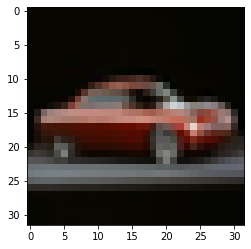

GIST descriptor: (256,)


In [ ]:
# get training data
(im_train, y_train), (im_test, y_test) = cifar10.load_data()
print('Training set size: {}'.format(im_train.shape))

# Parameters needed for the GIST descriptor
param = {
        "orientationsPerScale":np.array([8,8]),
         "numberBlocks":[4,4],
        "fc_prefilt":10,
        "boundaryExtension":32
}

# Extract the GIST descriptor of image 134
mygist = GIST(param)
imggray = cv2.cvtColor(im_train[134,:,:,:], cv2.COLOR_BGR2GRAY)
plt.imshow(im_train[134,:,:,:])
plt.show()
gistdesc = np.squeeze(mygist._gist_extract(imggray))
print('GIST descriptor: {}'.format(gistdesc.shape))

In [ ]:
# Transform the data so we only have a single value for each image
x_train = im_train.reshape(50000, 3*32*32)
x_test = im_test.reshape(10000, 3*32*32)
y_train = y_train.flatten()
y_test = y_test.flatten()

# Scale the data between 0 and 1 before using PCA so that we can express the
# number of components as a variance percentage
scaler = preprocessing.MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# We want the variance to be of 90%
pca = PCA(n_components=0.9)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [ ]:
# Logistic Regression with raw data
lr = LogisticRegression()
lr.fit(x_train_pca, y_train)
y_pred_logistic = lr.predict(x_test_pca)

print('Logistic Regression accuracy score:', accuracy_score(y_test, y_pred_logistic))

In [ ]:
# Support Vector Machine with raw data
svc = SVC()
svc.fit(x_train_pca, y_train)
y_pred_svc = svc.predict(x_test_pca)

print('SVC accuracy score:', accuracy_score(y_test, y_pred_svc))

In [ ]:
# Parameters needed for the GIST descriptor
param = {
        "orientationsPerScale":np.array([8,8]),
         "numberBlocks":[4,4],
        "fc_prefilt":10,
        "boundaryExtension":32
}

# Extract GIST descriptor of every image in the dataset
mygist = GIST(param)

n = 1000
x_train_gist = np.zeros((n,256))
x_test_gist = np.zeros((n,256))

for i in range(n):
  imggray = cv2.cvtColor(im_train[i,:,:,:], cv2.COLOR_BGR2GRAY)
  x_train_gist[i,:] = np.squeeze(mygist._gist_extract(imggray))

for i in range(n):
  imggray = cv2.cvtColor(im_test[i,:,:,:], cv2.COLOR_BGR2GRAY)
  x_test_gist[i,:] = np.squeeze(mygist._gist_extract(imggray))

y_train_gist = y_train[0:n]
y_test_gist = y_test[0:n]